# Part II
## Data analysis and classification

In this notebook we will try to combine the knowledge obtained via feature engineering in Part I into a unique classifier able to distinguish stars with exoplanets from stars without. 

The whole discussions and implementations discussed in Part I have been condensated into a `DataHandler` class that we leave in the notebook for reference, but we do not discuss in any detail. Refer to the notebook [Part I - Handling and visualizing data](./Part%20I%20-%20Handling%20and%20visualizing%20data.ipynb) for details.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import butter, filtfilt
from subprocess import run as run_shell
import ctypes
from multiprocessing.pool import ThreadPool
import random

class DataHandler:
    def __init__ (self, 
                  filepath="https://pandora.infn.it/public/806aa1/dl/exoTrain.csv",
                  filter_order=4,
                  filter_cutoff=0.02,
                  n_cores=4
                 ):
        self._filepath = filepath
        self.n_cores = n_cores
        
        self.dataframe = pd.read_csv(filepath)
        self.label = self.dataframe.LABEL.values
        self.data = self.preprocess(
            self.dataframe[self.dataframe.columns[1:]].values,
            filter_order=filter_order,
            filter_cutoff=filter_cutoff
        )
        
    
    @staticmethod
    def preprocess(data, filter_order, filter_cutoff):
        b, a = butter(filter_order, filter_cutoff)
        filtered = filtfilt(b, a, data)
        hf = data - filtered
        hf = (hf - hf.mean(axis=1, keepdims=True))/hf.std(axis=1, keepdims=True)
        hf = (hf - hf.mean(axis=0, keepdims=True))/hf.std(axis=0, keepdims=True)

        return hf
    
    @property
    def hourAxis (self):
        return np.arange(self.data.shape[1])*0.5
        
    @property
    def dayAxis (self):
        return self.hourAxis/24
    
    def filtered_amp (self, low, high, order=4):
        filtered = filtfilt(*butter(order, (low, high), btype='bandpass'), self.data)
        return np.min(filtered, axis=1)
    
    def count_crossings(self, threshold, length=1):
        data = self.data if threshold < 0 else -self.data
        return np.count_nonzero(
            np.all([data[:, (i):-(length-i)] < threshold for i in range(length)], axis=0) 
                    & (data[:, length:] > threshold), axis=1
        )

    def compute_periods(self, alpha):
        print("""
            #include <math.h>

            extern "C"
            void best_matching_period (int n, double alpha, double* lumi, int* best_period, double* min_score) {
                int i, j, k;
                double score;
                
                for (i = 100; i < n/2; ++i)
                    for (j = 1; j < i; ++j) {
                        score = 0;
                        for (k = j; k < n; k+= i) score += lumi[k];
                        score /= pow(n/i, alpha);
                        
                        if (score < *min_score) {
                            *min_score = score;
                            *best_period = i;
                        }
                    }
            }
            """, file=open('src.C', 'w'))
            
        libpath = f"./lib.{random.randint(0,0x7FFFF)}.so"
        run_shell(['gcc', '--shared', '-fPIC', '-o', libpath, 'src.C'])
                  
        lib = ctypes.CDLL(libpath)
        lib.best_matching_period.restype = ctypes.c_int
        lib.best_matching_period.argtypes = [
            ctypes.c_int, 
            ctypes.c_double, 
            np.ctypeslib.ndpointer(dtype=np.float64),
            np.ctypeslib.ndpointer(dtype=np.int32),
            np.ctypeslib.ndpointer(dtype=np.float64)
        ]
        
        pool = ThreadPool(self.n_cores)
        def get_period(row):
            best_period = np.array(0, dtype=np.int32)
            min_score = np.array(9999., dtype=np.float64)
            lib.best_matching_period(len(row), alpha, row, best_period, min_score);
            return int(best_period), float(min_score)

        return np.array(pool.map(get_period, list(self.data))).T


## Review of the feature engineering process
The feature engineering algorithms discussed in the previous notebook can be tuned by modifying some parameters.
In particular, we defined:
 * for the *Filtered amplitude* feature
     * the lower and higher cutoff frequency 
     * the order of the filter
 * for the number of crossings
     * the threshold to be crossed
     * the number of consecutive samples below threshold necessary to trigger an increment of the counter
 * for the period estimator
     * the constant $\alpha$ favouring long periods over fast, noisy fluctuations
     
Let's instanciate the `DataHandler` object to download the data and run the preprocessing step.

In [2]:
handler = DataHandler()

Let's start by choosing reasonable values for the parameters used in this reconstruction step.
We organize the three features that we are computing into a new `DataFrame` object.

In [3]:
period, score = handler.compute_periods(alpha=0.5)

dataframe = pd.DataFrame(dict(
    label=handler.label,
    famp=handler.filtered_amp(low=0.01, high=0.2, order=3),
    crossings=handler.count_crossings(threshold=-1.8, length=3),
    period=period, score=score
))

dataframe

,label,famp,crossings,period,score
0,2,-3.191704,19,1068.0,-10.208848
1,2,-5.238193,25,279.0,-20.434571
2,2,-3.778904,19,1446.0,-7.191040
3,2,-3.318393,15,1168.0,-5.994879
4,2,-4.762816,7,1076.0,-9.151447
...,...,...,...,...,...
5082,1,-2.240138,7,855.0,-4.046055
5083,1,-4.415717,13,1248.0,-5.488221
5084,1,-2.181687,2,1076.0,-4.514771
5085,1,-2.326750,0,1184.0,-2.761892


#### Filtered amplitude
Starting with the filtered amplitude feature, we compare the histogram of feature on the stars with and without exoplanets.
Clearly there is a difference between the two distributions, but how should we quantify the discriminant power of this feature?

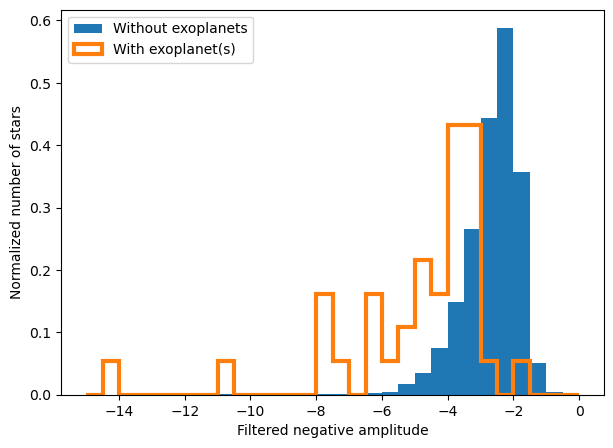

In [4]:
plt.figure(figsize=(7,5))
bins = np.linspace(-15, 0, 31)
plt.hist(dataframe.famp[dataframe.label==1], bins=bins, density=True, label="Without exoplanets")
plt.hist(dataframe.famp[dataframe.label==2], bins=bins, density=True, histtype='step', linewidth=3, label="With exoplanet(s)")
plt.xlabel("Filtered negative amplitude")
plt.ylabel("Normalized number of stars")
plt.legend()
plt.show()

A common metrics of the discriminant power of a classifier is the *Area Under the Receiver Operator Characteristic Curve* (AUC-ROC).

The ROC curve is defined as the curve connecting different working points of the classification task, usually obtained modifying the threshold of the requirement applied to classifier, on the plane *Background rejection* vs. *Signal efficiency*.

The ROC-AUC is the integral of the ROC.

Let's plot the AUC and then compute its integral (using, for example, the `np.trapz` function).

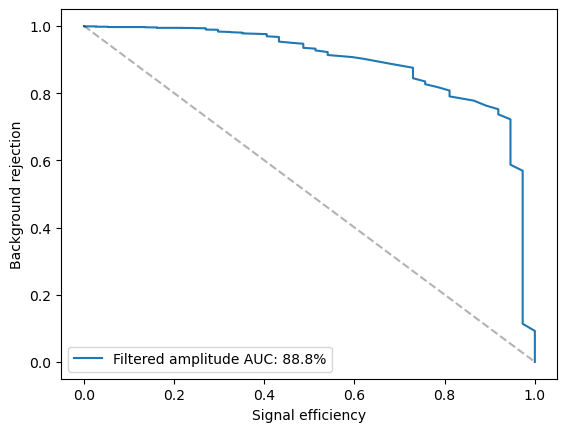

In [5]:
def draw_roc(y_true, y_score, title="Classifier"):
    ## Define an array of thresholds
    thresholds = np.linspace(y_score.max(), y_score.min(), 501)
    
    ## Compute the signal efficiencies and the rejections for each threshold
    eff = np.array([np.count_nonzero(y_score[y_true] > th) for th in thresholds])/np.count_nonzero(y_true)
    rej = np.array([np.count_nonzero(y_score[~y_true] < th) for th in thresholds])/np.count_nonzero(~y_true)
    
    ## Integrates the curve
    roc_auc = np.trapz(rej, eff)
    
    ## Build the plot
    plt.plot (eff, rej, label=title + f" AUC: {roc_auc*100:.1f}%")
    plt.plot ([0, 1], [1, 0], 'k--', alpha=0.3)
    plt.xlabel("Signal efficiency")
    plt.ylabel("Background rejection")
    
    
draw_roc(dataframe.label.values == 2, -dataframe.famp.values, "Filtered amplitude")
plt.legend(loc='lower left')
plt.show()

#### Number of crossings

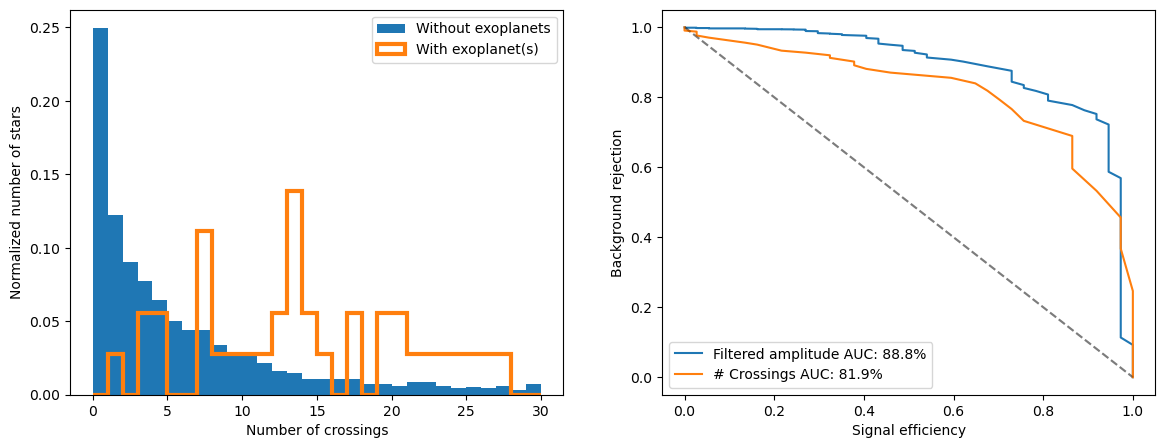

In [6]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
bins = np.linspace(0, 30, 31)
plt.hist(dataframe.crossings[dataframe.label==1], bins=bins, density=True, label="Without exoplanets")
plt.hist(dataframe.crossings[dataframe.label==2], bins=bins, density=True, histtype='step', linewidth=3, label="With exoplanet(s)")
plt.xlabel("Number of crossings")
plt.ylabel("Normalized number of stars")
plt.legend()

plt.subplot(1,2,2)
draw_roc(dataframe.label.values == 2, -dataframe.famp.values, "Filtered amplitude")
draw_roc(dataframe.label.values == 2, dataframe.crossings.values, "# Crossings")
plt.legend(loc='lower left')
plt.show()

#### Period estimator

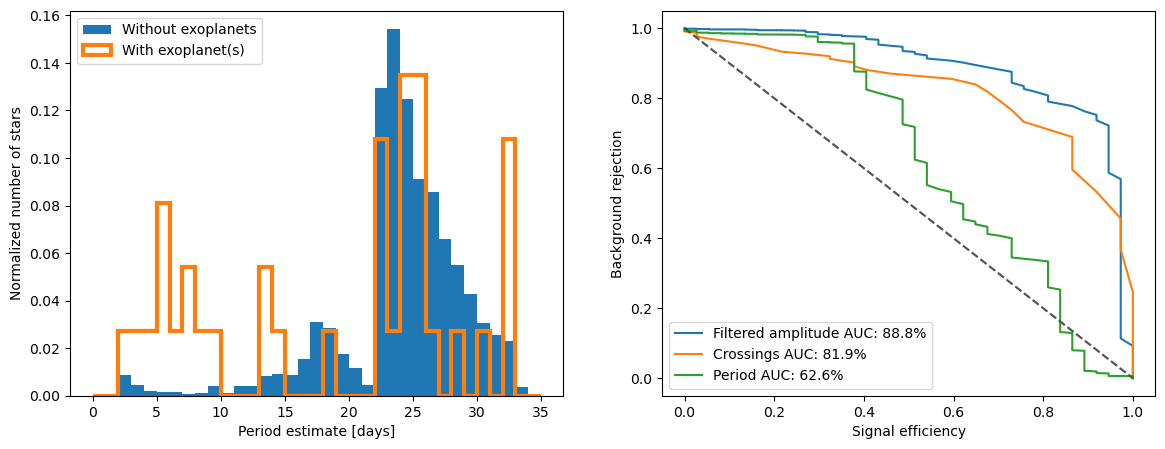

In [7]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
bins = np.linspace(0, 35, 36)
plt.hist(dataframe.period[dataframe.label==1]/48, bins=bins, density=True, label="Without exoplanets")
plt.hist(dataframe.period[dataframe.label==2]/48, bins=bins, density=True, histtype='step', linewidth=3, label="With exoplanet(s)")
plt.xlabel("Period estimate [days]")
plt.ylabel("Normalized number of stars")
plt.legend()

plt.subplot(1,2,2)
draw_roc(dataframe.label.values == 2, -dataframe.famp.values, "Filtered amplitude")
draw_roc(dataframe.label.values == 2, dataframe.crossings.values, "Crossings")
draw_roc(dataframe.label.values == 2, -dataframe.period.values, "Period")
plt.legend(loc='lower left')
plt.show()

#### Period estimator: score

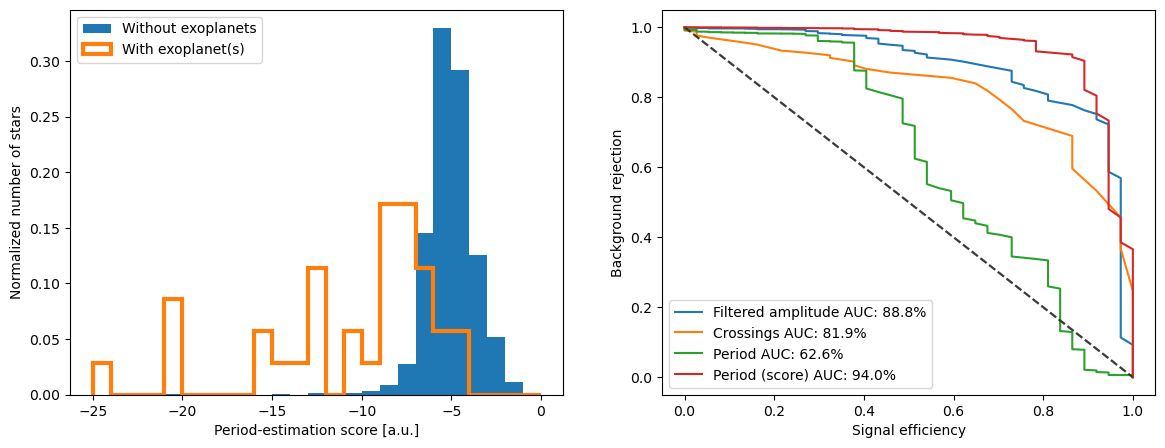

In [8]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
bins = np.linspace(-25, 0, 26)
plt.hist(dataframe.score[dataframe.label==1], bins=bins, density=True, label="Without exoplanets")
plt.hist(dataframe.score[dataframe.label==2], bins=bins, density=True, histtype='step', linewidth=3, label="With exoplanet(s)")
plt.xlabel("Period-estimation score [a.u.]")
plt.ylabel("Normalized number of stars")
plt.legend()

plt.subplot(1,2,2)
draw_roc(dataframe.label.values == 2, -dataframe.famp.values, "Filtered amplitude")
draw_roc(dataframe.label.values == 2, dataframe.crossings.values, "Crossings")
draw_roc(dataframe.label.values == 2, -dataframe.period.values, "Period")
draw_roc(dataframe.label.values == 2, -dataframe.score.values, "Period (score)")
plt.legend(loc='lower left')
plt.show()

## Build a multivatiate classifier

We are now ready to build a multivariate classifier combining the information from the features we computed so far.

Let's start by defining the input tensor $X$ and the label vector $y$.

In [9]:
X = dataframe[['famp', 'crossings', 'period', 'score']].values
y = dataframe['label'].values == 2

Then we split the sample in a training part and in a test part.
We remind that splitting the sample is necessary to evaluate, *a posteriori*, whether the model was overtrained, by comparing the performance achieved on the sample used for training and on a sample statistically equivalent but never actually used for training.

We will use the scikit-learn implementation of a simple algorithm splitting feature and labels in train and test samples.
See the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    data_train, data_test = handler.data[train_index], handler.data[test_index]

A good first choice to start evaluating what a multivariate classifier can achieve is provided by Random Forests.
In this case, it is mandatory to tune the hyperparameter of the Random Forest to limit the effect of overtraining.
To this end, we use very limited depth and a very large number of random estimators. 

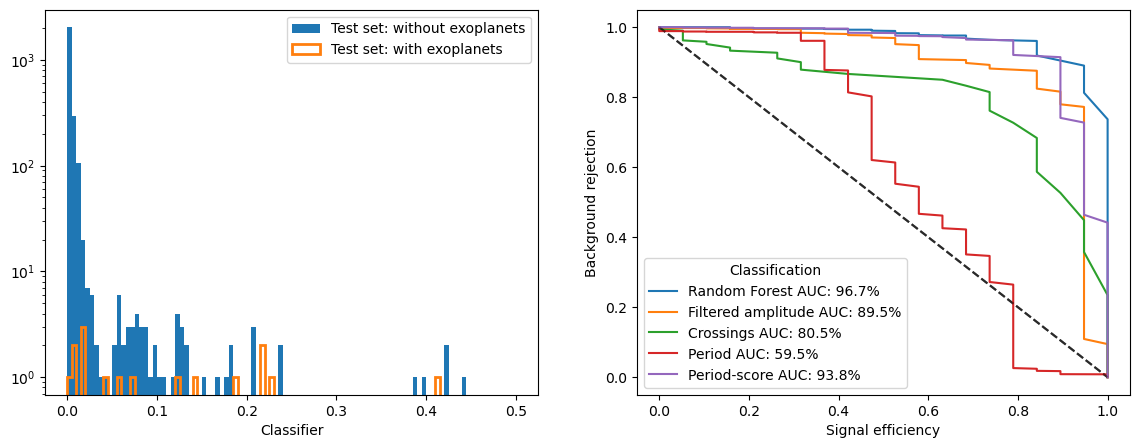

In [12]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=300, max_depth=3)
classifier.fit(X_train, y_train)

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)

y_score = classifier.predict_proba(X_train)[:,1]
y_score_test_rf = classifier.predict_proba(X_test)[:,1]
bins = np.linspace(0, 0.5, 101)
#plt.hist(y_score[~y_train], bins=bins)
#plt.hist(y_score[y_train], bins=bins, histtype='step', linewidth=2)
plt.hist(y_score_test_rf[~y_test], bins=bins, label="Test set: without exoplanets")
plt.hist(y_score_test_rf[y_test], bins=bins, histtype='step', linewidth=2, label="Test set: with exoplanets")
plt.yscale('log')
plt.xlabel("Classifier")
plt.legend()

plt.subplot(1,2,2)
#draw_roc(y_train, y_score, "Train")
draw_roc(y_test, y_score_test_rf, "Random Forest")
draw_roc(y_test, -X_test[:,0], "Filtered amplitude")
draw_roc(y_test, X_test[:,1], "Crossings")
draw_roc(y_test, -X_test[:,2], "Period")
draw_roc(y_test, -X_test[:,3], "Period-score")

plt.legend(title="Classification")
plt.show()

## Replace feature engineering with Deep Learning

Feature engineering is an extremely domain-specific, time- and often human-brain- consuming task. 
Ideally, one would like to offload the identification of the features (or more generally of the ***representation***) to an algorithm.

Deep Learning has the potential to provide a solution to automatically learn the optimzal representation of a dataset for a specific task. However, reasoning such as "*the planet passing between the camera and the observer should give a periodic behaviour and the fact the time spent by the planet between the star and the camera should be much smaller than its period*" cannot be guessed by the algorithm but statistically learning them from data.

This means that a large amount of statistics is needed for the network to learn by experience that a representation works better than another. Large statistics is needed to distinguish a good representation from a statistical fluctuation of the training dataset which allows, by chance, for a good separation between the two categories.

When the statistics is limited (as in this case) it is often a rather bad idea to blindly rely on Deep Learning, and feature engineering with domain-related knowledge might be a more robust solution. 
However, it is still interesting (and certainly educational) to tweak a deep neural network to learn a good representation of the problem. 



### Deep Neural Network architecture
We aim at developing an algorith that takes as an input the luminosity stream and provides the probability that star has exoplanets as an output.
A dense architecture would see the number of weights exploding while adding the first layers and would be very difficult to train properly with only few tens of examples of one of the categories. 

Hence, we will try with a Convolutional Neural Network trying to learn local features (such as *here a planet has passed in front of the star*) and global features (such as *the planet passes periodically in front of the star*).

We will define a relatively small network with extremely high regularization constants to fight against overtraining, trying to push the training towards minima that generalize better.

The number of weights is still rather large (2k) if compared to the number of datasets, but we introduced important constraints to the correlation of these weights and are ready to make a trial.
Be careful: whatever regularization strategy you adopt, overtraining may happen.

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPool1D, Dense, Flatten
from tensorflow.keras.optimizers import Adam

raw = Input(shape=(handler.data.shape[1], 1))
x = Conv1D(filters=4, kernel_size=11, activation='tanh', kernel_regularizer=tf.keras.regularizers.L2(.01)) (raw)
x = Conv1D(filters=4, kernel_size=11, activation='tanh', kernel_regularizer=tf.keras.regularizers.L2(.01)) (x)
x = Conv1D(filters=4, kernel_size=11, activation='tanh', kernel_regularizer=tf.keras.regularizers.L2(.01)) (x)
x = MaxPool1D(5) (x)
x = Conv1D(filters=4, kernel_size=11, activation='tanh', input_shape=[handler.data.shape[1],1], kernel_regularizer=tf.keras.regularizers.L2(.1)) (x)
x = Conv1D(filters=4, kernel_size=11, activation='tanh', kernel_regularizer=tf.keras.regularizers.L2(.01)) (x)
x = Conv1D(filters=4, kernel_size=11, activation='tanh', kernel_regularizer=tf.keras.regularizers.L2(.01)) (x)
x = MaxPool1D(5) (x)
x = Conv1D(filters=4, kernel_size=11, activation='tanh', input_shape=[handler.data.shape[1],1], kernel_regularizer=tf.keras.regularizers.L2(.1)) (x)
x = Conv1D(filters=4, kernel_size=11, activation='tanh', kernel_regularizer=tf.keras.regularizers.L2(.01)) (x)
x = Conv1D(filters=4, kernel_size=11, activation='tanh', kernel_regularizer=tf.keras.regularizers.L2(.01)) (x)
x = MaxPool1D(5) (x)
x = Flatten()(x)
x = Dense(8, activation='tanh', kernel_regularizer=tf.keras.regularizers.L2(.01)) (x)
x = Dense(1, activation='sigmoid') (x)

model = Model(inputs=(raw), outputs=x)


model.summary()

2022-12-02 09:06:41.837842: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3197, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 3187, 4)           48        
                                                                 
 conv1d_1 (Conv1D)           (None, 3177, 4)           180       
                                                                 
 conv1d_2 (Conv1D)           (None, 3167, 4)           180       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 633, 4)           0         
 )                                                               
                                                                 
 conv1d_3 (Conv1D)           (None, 623, 4)            180       
                                                             

2022-12-02 09:06:47.473266: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Balancing the dataset for an improved training

We need to perform a training with a large, highly unbalanced training set.
If the dataset was smaller, we could simply perform every step of the training on the whole dataset, but with such a large dataset (where large here refers to the size in bytes, not to the number of items) the training would be too slow.

The solution that we usually adopt in this case is to train in batches. We divide our sample in small subsamples and we consider them as our training dataset for one step. To avoid numerical effects related to the specific composition of a batch through the training epochs, batches are often randomized. 

But our dataset is highly unbalanced, meaning that most of the batches would contain only one class which is clearly not optimal for training purposes. 

A possible solution is to stream random batches with a constant amount of examples for each category, making sure we do never provide examples from the test sample to the training procedure, and vice-versa we do not use training example for validation.

The following function (a Python generator) provides a possible implementation of this approach.

In [14]:
def batch_generator(data, label, batch_size=32, test_set=False):
    """
    Gives equal number of positive and negative samples picked from either the training or the test set.
    """
    
    half_batch = batch_size // 2
    
    ## Let's call "0" and "1" the two categories (with and without exoplanets)
    ## d0 and d1 will be the datasets corresponding to the two categories
    d0 = data[label == 0, :, None]
    d1 = data[label == 1, :, None]
    
    ## We reserve the last part of the dataset for testing and we never
    ## access it unless the test_set flag is True.
    d0_train, d0_test = d0[:len(d0)//2], d0[len(d0)//2:]
    d1_train, d1_test = d1[:len(d1)//2], d1[len(d1)//2:]
    
    d0 = d0_test if test_set else d0_train
    d1 = d1_test if test_set else d1_train
     
    ## Then, iteratively 
    while True:
        if test_set:
            id0 = np.arange(min(half_batch, len(d0)))
            id1 = np.arange(min(half_batch, len(d1)))
        else:
            id0 = np.random.randint(0, len(d0), half_batch)
            id1 = np.random.randint(0, len(d1), half_batch)

        x_batch = np.concatenate((d0[id0], d1[id1]), axis=0)
        y_batch = np.concatenate((np.zeros(len(id0)), np.ones(len(id1))), axis=0)                                
        
        yield x_batch, y_batch

### Training the neural network
Now we do have all the ingredients to train the network.

Keras makes it simple to include the computation of the ROC-AUC in the network training procedure and to compute it at each iteration for both the training and the test sets. 

In the next code block we define the test set by taking the first occurence yielded by the `batch_generator` run with `test_set=True`, then we compile the model choosing the optimizer, the loss and the metrics to include in the history, and finally we fire up the training procedure.


In [15]:
from tensorflow.keras.metrics import AUC
x_test_cnn, y_test_cnn = next(iter(batch_generator(handler.data, handler.label==2, 40, test_set=True)))
model.compile(optimizer=Adam(3e-4), loss = 'binary_crossentropy', metrics=['accuracy', AUC(name='roc-auc')])
history = model.fit(
    batch_generator(handler.data, handler.label==2, 40), 
    validation_data=(x_test_cnn, y_test_cnn), 
    verbose=False, 
    epochs=300, 
    steps_per_epoch=1
)

#### Plotting the training history
In the next code block we just represent the training procedure.
We can observe that the network is slightly overtrained because it stops improving its performance on the test set while it continues to decrease the loss value on the test set. 
Still the discrimination power of the classifier as measured by the ROC-AUC keeps increasing gently till the end of the training.


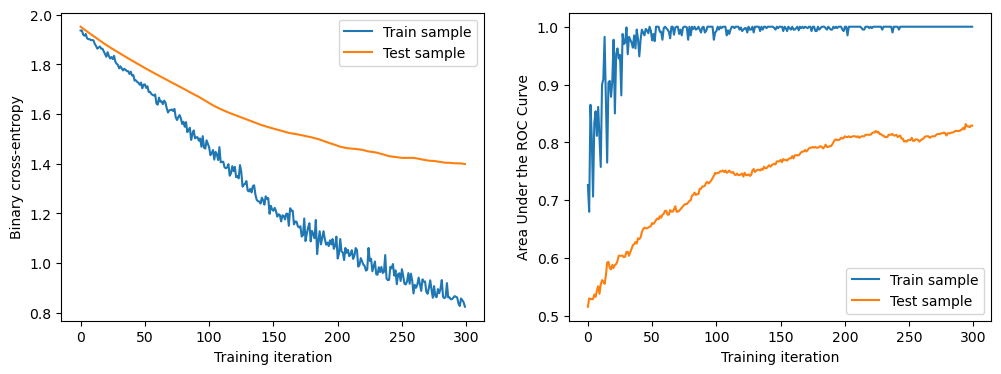

In [16]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label="Train sample")
plt.plot(history.history['val_loss'], label="Test sample")
plt.xlabel("Training iteration")
plt.ylabel("Binary cross-entropy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['roc-auc'], label="Train sample")
plt.plot(history.history['val_roc-auc'], label="Test sample")
plt.xlabel("Training iteration")
plt.ylabel("Area Under the ROC Curve")

plt.legend()

### Comparison with the feature-engineered classifier

Finally, we compare the classifier obtained by the DNN with the previously-trained Random Forest.
As expected, domain-specific knowledge is difficult to outperform with such a limited statistics, but the DNN is able to define a classifier that is at the level, or better, than most of the engineered features taken singularly, and has been obtained blindly with respect to the specific problem, letting the DNN to digest the raw information in the dataset.

That's remarkable!

With large training datasets, DNNs can outperform classification algorithms based on feature-enginereed by obtaining an optimal representation of the problem.

(519, 3197, 1)
17/17 [==============================] - 0s 15ms/step


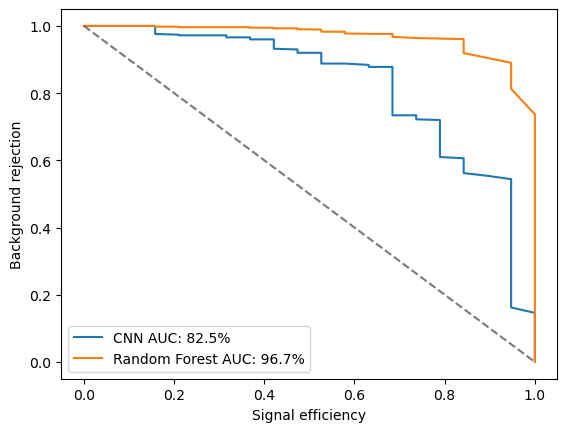

In [17]:
x_test_cnn, y_test_cnn = next(iter(batch_generator(handler.data, handler.label==2, 1000, test_set=True)))
print (x_test_cnn.shape)
y_score_cnn = model.predict(x_test_cnn).flatten()
draw_roc(y_test_cnn==1, y_score_cnn, "CNN")
draw_roc(y_test, y_score_test_rf, "Random Forest")
plt.legend()

# Exercises

In each of the following exercises you will be requested to define a classifier.

**Please, make sure you plot the relevant ROC curve and compute the AUC.**

### Exercise 2.1 - Logistic regression ⏳

Try to replace the Random Forest classifier with a [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) as defined in the module `sklearn.linear_model`.


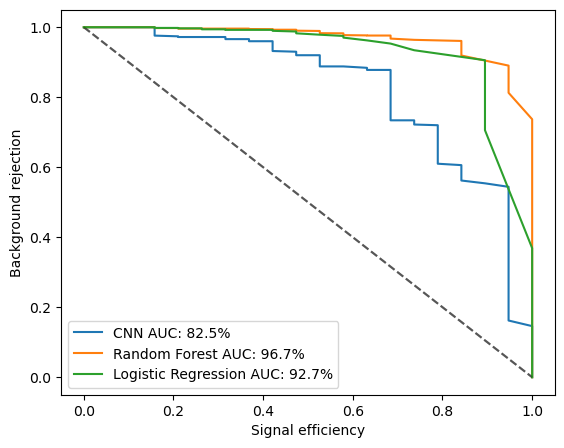

In [18]:
from sklearn.linear_model import LogisticRegression 
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)

y_score_train_lr = log_reg.predict_proba(X_train)[:,1]
y_score_test_lr = log_reg.predict_proba(X_test)[:,1]

draw_roc(y_test_cnn==1, y_score_cnn, "CNN")
draw_roc(y_test, y_score_test_rf, "Random Forest")
draw_roc(y_test, y_score_test_lr, "Logistic Regression")

plt.legend(loc="lower left")
plt.show()

### Exercise 2.2 - Scikit-learn Multi Layer Perceptron (MLP)  ⏳⏳

Scikit-learn provides its own implementation of ANNs. While much less complete than keras and therefore limited in terms of potential application, scikit-learn makes it immediate to test the application of neural network to tabular classification tasks.

Have a look to the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier) and give it a try. 

> **Hint.** Compare the results obtained with different activation functions. Can you guess the reason behind the observed behaviour?

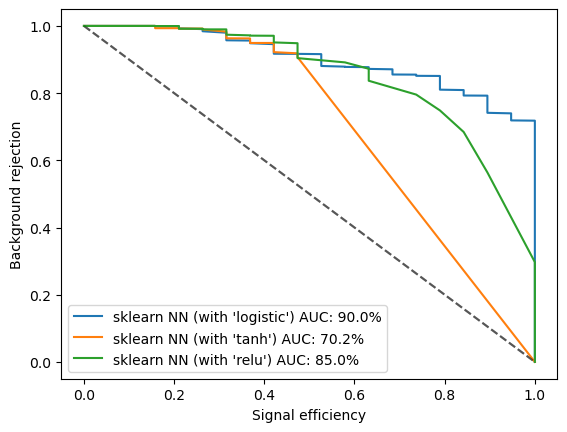

In [19]:
from sklearn.neural_network import MLPClassifier

for activation in ['logistic', 'tanh', 'relu']:
    nn_sklearn = MLPClassifier((64, 64, 64, 64, 64), activation=activation, batch_size=128, learning_rate='adaptive')
    nn_sklearn.fit(X_train, y_train)
    
    y_score_train_sknn = nn_sklearn.predict_proba(X_train)[:,1]
    y_score_test_sknn = nn_sklearn.predict_proba(X_test)[:,1]
    
    draw_roc(y_test, y_score_test_sknn, f"sklearn NN (with '{activation}')")
    
plt.legend(loc="lower left")
plt.show()

### Exercise 2.3 - Preprocess the input  ⏳

We have seen how preprocessing is important in [Part I - Handling and visualizing data](./Part%20I%20-%20Handling%20and%20visualizing%20data.ipynb). Similar consieration apply also to the engineered features, especially when numerical optimization is performed as in the case of Logistic Regression.

Try to *standardize* the input features as discussed in Part I, or using `sklearn.preprocessing` module (see the [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) class) 
and compare the performance of the MLP obtained with and without standardization.

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)

prep_X = scaler.transform(X)
prep_X_train = scaler.transform(X_train)
prep_X_test = scaler.transform(X_test)

In [21]:
#nn_sklearn = MLPClassifier((64, 64, 64, 64, 64), activation='tanh', batch_size=128, learning_rate='adaptive')
#nn_sklearn.fit(data_train, y_train)

#y_score_test_raw = nn_sklearn.predict_proba(data_test)[:,1]
    
#draw_roc(y_test, y_score_test_raw, "sklearn NN on raw data")
#plt.legend()
#plt.show()

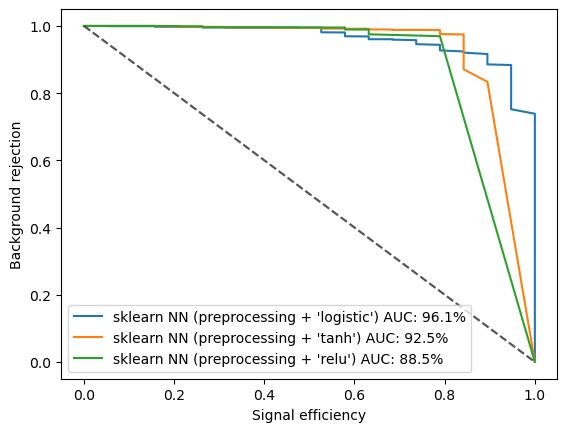

In [22]:
for activation in ['logistic', 'tanh', 'relu']:
    nn_sklearn = MLPClassifier((64, 64, 64, 64, 64), activation=activation, batch_size=128, learning_rate='adaptive')
    nn_sklearn.fit(prep_X_train, y_train)
    
    y_score_train_sknn = nn_sklearn.predict_proba(prep_X_train)[:,1]
    y_score_test_sknn = nn_sklearn.predict_proba(prep_X_test)[:,1]
    
    draw_roc(y_test, y_score_test_sknn, f"sklearn NN (preprocessing + '{activation}')")
    
plt.legend(loc="lower left")
plt.show()

### Exercise 2.4 - k-Fold cross-validation  ⏳⏳⏳

A trick to increase the statistics of the training sample is to train the algorithm multiple time on different portions of the training set, using the other remaining samples for validation.

Having a look to the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) and the example included, try to apply cross-validation to one of the method discussed above.

> **Hint.** Trying it out with the MLP might be a bad idea because of the longer training time of this algorithm.

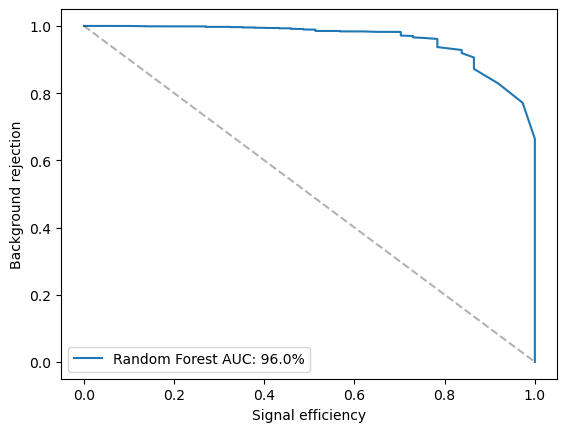

In [23]:
from sklearn.model_selection import StratifiedKFold

y_score_test_rfc_kf = np.zeros_like(y).astype(np.float32)

skf = StratifiedKFold(n_splits=5, shuffle=False)
for train_index, test_index in skf.split(prep_X, y):
    prep_X_train_kf, prep_X_test_kf = prep_X[train_index], prep_X[test_index]
    y_train_kf, y_test_kf = y[train_index], y[test_index]
    
    rfc = RandomForestClassifier(n_estimators=300, max_depth=3)
    rfc.fit(prep_X_train_kf, y_train_kf)
    
    y_score_test_rfc_kf[test_index] = rfc.predict_proba(prep_X_test_kf)[:,1]
    
draw_roc(y, y_score_test_rfc_kf, "Random Forest")
plt.legend()
plt.show()

### Exercise 2.5 - The Ultimate Model  ⏳⏳⏳⏳⏳⏳ (a.k.a. Bonus Track 🤯)  

Ok, this won't be easy.

We have seen that MLP (a Dense Neural Network) performs rather well on engineered features, achieving almost the same score as the Random Forest Classifier, setting our record. At the same time the CNN (another Neural Network) was able to digest the raw data, without any domain-specific knowledge, and obtain decent classification performance.

Can we take a neural network that takes as an input the raw data AND the engineered features to combine the information into a unique top-performing classifier?

In other words, can we capture the residual information that our feature engineering process was unable to grasp using a convolutional neural network?

Give it a try!

1. Extend the Neural Network model that we discussed above to take as an input of the Dense layer both a combination of the output of the convolutional trunk (as in the example) and the preprocessed (see Ex. 2.3) engineered features. 
> **Hint.** Have a look to the [Concatenate](https://keras.io/api/layers/merging_layers/concatenate/) layer in Keras.

2. Modify the `batch_generator` function to:
 * take the preprocessed engineered features as an additional input
 * return random batches in the format
     ```
     ...
     yield (x_batch, f_batch), y_batch
     ```
     where `x_batch` and `y_batch` are the raw data and the labels as in the original example, and `f_batch` is the 
     array of the corresponding engineered features.

3. Train and tune the model to bring it to convergence and compute the ROC-AUC score on the validation data.
With some patience you may be able to achieve a better score than the Random Forest classifier.


In [24]:
from tensorflow.keras.layers import Concatenate


raw = Input(shape=(handler.data.shape[1], 1))
cnn_out = Conv1D(filters=4, kernel_size=11, activation='tanh', kernel_regularizer=tf.keras.regularizers.L2(.01)) (raw)
cnn_out = Conv1D(filters=4, kernel_size=11, activation='tanh', kernel_regularizer=tf.keras.regularizers.L2(.01)) (cnn_out)
cnn_out = Conv1D(filters=4, kernel_size=11, activation='tanh', kernel_regularizer=tf.keras.regularizers.L2(.01)) (cnn_out)
cnn_out = MaxPool1D(5) (cnn_out)
cnn_out = Conv1D(filters=4, kernel_size=11, activation='tanh', input_shape=[handler.data.shape[1],1], kernel_regularizer=tf.keras.regularizers.L2(.1)) (cnn_out)
cnn_out = Conv1D(filters=4, kernel_size=11, activation='tanh', kernel_regularizer=tf.keras.regularizers.L2(.01)) (cnn_out)
cnn_out = Conv1D(filters=4, kernel_size=11, activation='tanh', kernel_regularizer=tf.keras.regularizers.L2(.01)) (cnn_out)
cnn_out = MaxPool1D(5) (cnn_out)
cnn_out = Conv1D(filters=4, kernel_size=11, activation='tanh', input_shape=[handler.data.shape[1],1], kernel_regularizer=tf.keras.regularizers.L2(.1)) (cnn_out)
cnn_out = Conv1D(filters=4, kernel_size=11, activation='tanh', kernel_regularizer=tf.keras.regularizers.L2(.01)) (cnn_out)
cnn_out = Conv1D(filters=4, kernel_size=11, activation='tanh', kernel_regularizer=tf.keras.regularizers.L2(.01)) (cnn_out)
cnn_out = MaxPool1D(5) (cnn_out)
cnn_out = Flatten()(cnn_out)

x = Input(shape=(X.shape[1],))
mlp_out = Dense(8, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(.01)) (x)
mlp_out = Dense(16, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(.01)) (mlp_out)
mlp_out = Dense(32, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(.01)) (mlp_out)

concatted = tf.keras.layers.Concatenate()([cnn_out, mlp_out])
out = Dense(32, activation='tanh', kernel_regularizer=tf.keras.regularizers.L2(.01)) (concatted)
out = Dense(16, activation='tanh', kernel_regularizer=tf.keras.regularizers.L2(.01)) (out)
out = Dense(8, activation='tanh', kernel_regularizer=tf.keras.regularizers.L2(.01)) (out)
out = Dense(1, activation='sigmoid') (out)


model = Model(inputs=[raw, x], outputs=out)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 3197, 1)]    0           []                               
                                                                                                  
 conv1d_9 (Conv1D)              (None, 3187, 4)      48          ['input_2[0][0]']                
                                                                                                  
 conv1d_10 (Conv1D)             (None, 3177, 4)      180         ['conv1d_9[0][0]']               
                                                                                                  
 conv1d_11 (Conv1D)             (None, 3167, 4)      180         ['conv1d_10[0][0]']              
                                                                                            

In [25]:
def my_batch_generator(data, label, batch_size=32, test_set=False):
    """
    Gives equal number of positive and negative samples picked from either the training or the test set.
    """
    
    raw, x = data
    
    half_batch = batch_size // 2
    
    ## Let's call "0" and "1" the two categories (with and without exoplanets)
    ## d0 and d1 will be the datasets corresponding to the two categories
    d0 = raw[label == 0, :, None]
    d1 = raw[label == 1, :, None]
    
    f0 = x[label == 0, :]
    f1 = x[label == 1, :]
    
    ## We reserve the last part of the dataset for testing and we never
    ## access it unless the test_set flag is True.
    d0_train, d0_test = d0[:len(d0)//2], d0[len(d0)//2:]
    d1_train, d1_test = d1[:len(d1)//2], d1[len(d1)//2:]
    
    f0_train, f0_test = f0[:len(f0)//2], f0[len(f0)//2:]
    f1_train, f1_test = f1[:len(f1)//2], f1[len(f1)//2:]
    
    d0 = d0_test if test_set else d0_train
    d1 = d1_test if test_set else d1_train
    
    f0 = f0_test if test_set else f0_train
    f1 = f1_test if test_set else f1_train
     
    ## Then, iteratively 
    while True:
        if test_set:
            id0 = np.arange(min(half_batch, len(d0)))
            id1 = np.arange(min(half_batch, len(d1)))
        else:
            id0 = np.random.randint(0, len(d0), half_batch)
            id1 = np.random.randint(0, len(d1), half_batch)

        x_batch = np.concatenate((d0[id0], d1[id1]), axis=0)
        f_batch = np.concatenate((f0[id0], f1[id1]), axis=0)
        y_batch = np.concatenate((np.zeros(len(id0)), np.ones(len(id1))), axis=0)                                
        
        yield (x_batch, f_batch), y_batch

In [26]:
from tensorflow.keras.metrics import AUC

x_test_cnn, y_test_cnn = next(iter(my_batch_generator([data_train, prep_X_train], y_train, 40, test_set=True)))
model.compile(optimizer=Adam(3e-4), loss = 'binary_crossentropy', metrics=['accuracy', AUC(name='roc-auc')])
history = model.fit(
    my_batch_generator([data_train, prep_X_train], y_train, 40), 
    validation_data=(x_test_cnn, y_test_cnn), 
    verbose=False, 
    epochs=300, 
    steps_per_epoch=1
)

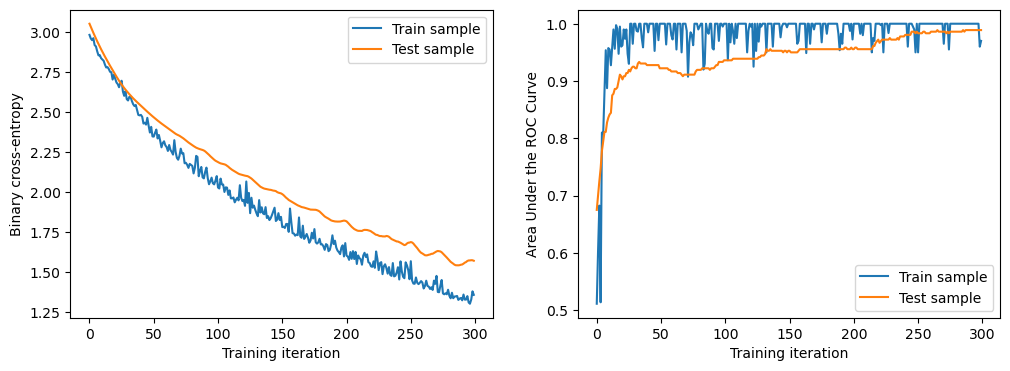

In [27]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label="Train sample")
plt.plot(history.history['val_loss'], label="Test sample")
plt.xlabel("Training iteration")
plt.ylabel("Binary cross-entropy")
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['roc-auc'], label="Train sample")
plt.plot(history.history['val_roc-auc'], label="Test sample")
plt.xlabel("Training iteration")
plt.ylabel("Area Under the ROC Curve")

plt.legend()
plt.show()

17/17 [==============================] - 0s 15ms/step


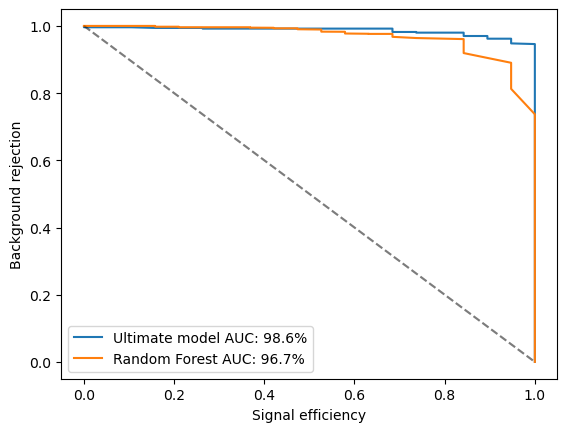

In [28]:
x_test_cnn, y_test_cnn = next(iter(my_batch_generator([handler.data, prep_X], handler.label==2, 1000, test_set=True)))
y_score_cnn = model.predict(x_test_cnn).flatten()
draw_roc(y_test_cnn==1, y_score_cnn, "Ultimate model")
draw_roc(y_test, y_score_test_rf, "Random Forest")
plt.legend()
plt.show()